# Day 2

## Data Engineering and Machine Learning

Yesterday we cleaned some data, and did a basic analysis. In the end we used that to fit our own model. Now, we will do some more advanced data engineering, and end with machine learning techniques that optimize the model


### Day 1 Redo

Redoing the things we did in the day 1 notebook:

In [ ]:
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com pandas;
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com seaborn;  
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com scipy;
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com matplotlib;   
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com boto3;
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com wrapt==1.11.0;
!pip install --index-url https://repo.dtcc.com/repository/dtcc-pypi-public/simple --trusted-host repo.dtcc.com s3fs sklearn;

In [338]:
import numpy as np #for advanced math
import pandas as pd #for data manipulation
pd.set_option('max_columns', 105) #this makes everything nicer to read
import matplotlib.pyplot as plt #for plotting!
import seaborn as sns #for pretty and easy to use plotting! works with plt
from scipy import stats #for stats things
import boto3 #to handle files in s3
import s3fs #to import those files into a pandas dataframe
from sklearn.linear_model import LinearRegression #to draw our line of best fit!
%matplotlib inline
sns.set() 

import warnings 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")
#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

full_dataset =  pd.read_csv('s3://sag-dev-risk-sagemaker-yolo/sharing/madlabdata/AmesHousing.csv')
target = pd.read_csv('s3://sag-dev-risk-sagemaker-yolo/sharing/madlabdata/target.csv') #sales price - what we're trying to predict
train = pd.read_csv('s3://sag-dev-risk-sagemaker-yolo/sharing/madlabdata/train.csv') #what we use to create the model - called 'training'
#test =  pd.read_csv('s3://sag-dev-risk-sagemaker-yolo/sharing/madlabdata/test.csv') #what we use to check our created model - 'testing'
test_big = pd.concat([full_dataset,train]).drop_duplicates(keep=False)
test = test_big[0:500]

train['SalePrice_Log'] = np.log(train['SalePrice'])
test['SalePrice_Log'] = np.log(test['SalePrice'])
numerical_feats = train.dtypes[train.dtypes != "object"].index
categorical_feats = train.dtypes[train.dtypes == "object"].index
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['Pool QC','Misc Feature','Alley','Fence','Mas Vnr Type','Fireplace Qu',
               'Garage Qual','Garage Cond','Garage Finish','Garage Type', 'Electrical',
               'Kitchen Qual', 'Sale Type', 'Functional', 'Exterior 2nd', 'Exterior 1st',
               'Bsmt Exposure','Bsmt Cond','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2',
               'MS Zoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    test[col].fillna('None',inplace=True)
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)
for df in [train, test]:
    df['GrLivArea_Log'] = np.log(df['Gr Liv Area'])
    df.drop('Gr Liv Area', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['Lot Area'])
    df.drop('Lot Area', inplace= True, axis = 1)
    
numerical_feats = train.dtypes[train.dtypes != "object"].index

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

# Session 2:

    Plan for the session
        3. Data wrangling - dropping irrelevent columns
        4. Categorical variable transformations
        5. log transforms?
        6. ML Linear Regression
        7. ML Random Forest
        
        **Drop all columns with only small correlation to SalePrice**  

**Transform Categorical to numerical**  

**Log values, and other data transforms**

**Machine learning regression**

**Machine Learning random forest**


### 3 Correlation

Positive correlation indicates that two variables will move in the same direction. In other words, if one variable increases, the other will increase as well, and if one variable decreases the other decreases equivalently.

A negative correlation is a relationship between two variables in which the increase in one variable leads to a decrease in the other. A good example of a negative correlation is the amount of oxygen to altitude. With an increase in altitude, the oxygen levels in the air will decrease


<div> <img src="https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/05/strong-positive-and-negative-correlation.png" style="width: 800px;"/></div> 


**Goal: Find columns with strong correlation to target**  - find the features with a strong correlation to SalePrice_Log (our target variable).  The more related the feature is to the target, the better it will be at predicting/explaining trends. To make things easier, we will only be keeping variables if they have at least a correlation of 0.4 with the outcome

## 3.1  Find Strong Correlation Coefficient to the Target

First we generate lists of numerical features where they have AT LEAST 0.4 correlation to the target (SalePrice_Log)

In [339]:
min_val_corr = 0.4
corr = train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)['SalePrice_Log']

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)


In [340]:
#print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)
nr_feats = len(cols_abv_corr_limit)

******************************
List of numerical features with r above min_val_corr :
['Year Remod/Add', 'Overall Qual', 'Year Built', 'Garage Yr Blt', 'Full Bath', 'SalePrice_Log', 'Garage Area', 'Mas Vnr Area', 'SalePrice', 'Garage Cars', 'BsmtFin SF 1', 'Fireplaces', 'Total Bsmt SF', 'GrLivArea_Log', '1st Flr SF', 'TotRms AbvGrd']
******************************
List of numerical features with r below min_val_corr :
['Order', 'Yr Sold', 'PID', 'Mo Sold', 'Pool Area', 'LotArea_Log', 'Half Bath', 'Bsmt Full Bath', 'Wood Deck SF', 'Overall Cond', 'MS SubClass', 'Enclosed Porch', '3Ssn Porch', 'Low Qual Fin SF', 'Kitchen AbvGr', 'Misc Val', 'Bedroom AbvGr', 'Lot Frontage', 'Screen Porch', '2nd Flr SF', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Open Porch SF', 'Bsmt Half Bath']


In [341]:
cols_bel_corr_limit.remove('Order')

#### Find Strong Correlation Coefficient in Categorical Variables

This was derived by Looking at the plots made from day one, and pulling out variables that seemed to have some correlation

In [342]:
catg_strong_corr = [ 'MS Zoning', 'Neighborhood', 'Condition 2', 'Mas Vnr Type', 'Exter Qual', 
                     'Bsmt Qual','Central Air', 'Electrical', 'Kitchen Qual', 'Sale Type']

catg_weak_corr = ['Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 
                  'Land Slope', 'Condition 1',  'Bldg Type', 'House Style', 'Roof Style', 
                  'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Cond', 'Foundation', 
                  'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 
                  'Heating QC', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 
                  'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 
                  'Sale Condition' ]

### Dropping all columns with weak correlation to SalePrice

Now we get rid of all columns that did not meet that threshold

In [343]:
to_drop_num  = cols_bel_corr_limit #numerical features
to_drop_catg = catg_weak_corr #categorical features

cols_to_drop =to_drop_num + to_drop_catg 

for df in [train, test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)


In [344]:
train.head()

,Order,MS Zoning,Neighborhood,Condition 2,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Type,Mas Vnr Area,Exter Qual,Bsmt Qual,BsmtFin SF 1,Total Bsmt SF,Central Air,Electrical,1st Flr SF,Full Bath,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Sale Type,SalePrice,SalePrice_Log,GrLivArea_Log
0,534,RL,SawyerW,Norm,7,2007,2007,None,0.0,Gd,Gd,0.0,1218.0,Y,SBrkr,1218,1,Gd,6,0,2007.0,2.0,576.0,WD,159000,11.976659,7.104965
1,803,RL,SawyerW,Norm,7,1990,1991,BrkFace,234.0,Gd,Gd,485.0,2158.0,Y,SBrkr,2196,2,Gd,7,1,1990.0,3.0,701.0,WD,271900,12.513190,7.694393
2,956,RL,Timber,Norm,6,1958,1958,BrkFace,541.0,TA,TA,111.0,819.0,Y,FuseA,1344,1,Gd,7,1,1958.0,2.0,525.0,COD,137500,11.831379,7.203406
3,460,RL,NridgHt,Norm,9,2008,2008,BrkFace,500.0,Ex,Ex,0.0,1451.0,Y,SBrkr,1456,2,Ex,6,1,2008.0,2.0,539.0,WD,248500,12.423198,7.283448
4,487,RL,Gilbert,Norm,7,2004,2004,None,0.0,Gd,Gd,241.0,384.0,Y,SBrkr,744,2,Gd,7,0,2004.0,2.0,400.0,WD,167000,12.025749,7.225481


## 3.2 Convert categorical columns to numerical  

Taking a Second Look: 

To investigate the relation of the categories to SalePrice in more detail, we make boxenplots for these features

For those categorcial features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the category, we transform the columns to numerical.

Here is the link to the data dictionary: [**AmStat Data Dictionary**](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)


Here's a short summary:

    Categorical :
        MS Zoning - general zoning classification ie. Agricultural, commercial etc.
        Neighborhood
        Mas Vnr Type - masonry veneer type ie. brick, cinder block etc.
        Exter Qual 
        Bsmt Qual
        Central Air
        Electrical
        Kitchen Quality
        Sale type - ie. warranty deed, contract low interest, etc.


Notice the categories - do you see any that could be merged?  

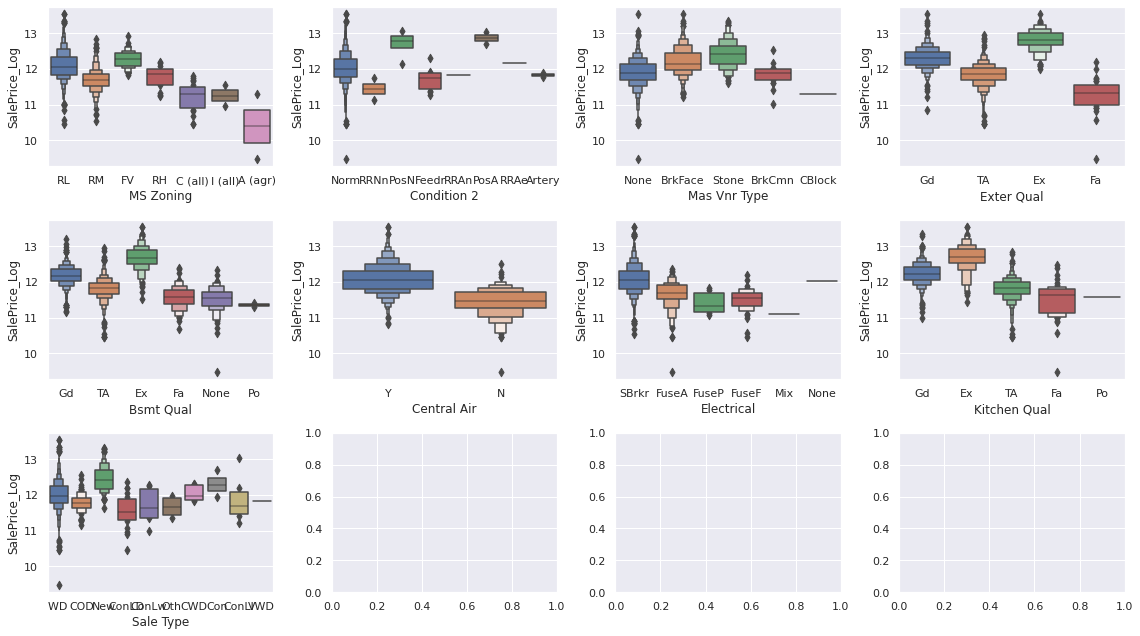

In [345]:
li_cat_feats = catg_strong_corr.copy()
li_cat_feats.remove('Neighborhood')
nr_rows = 3
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxenplot(x=li_cat_feats[i], y=train['SalePrice_Log'], data=train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

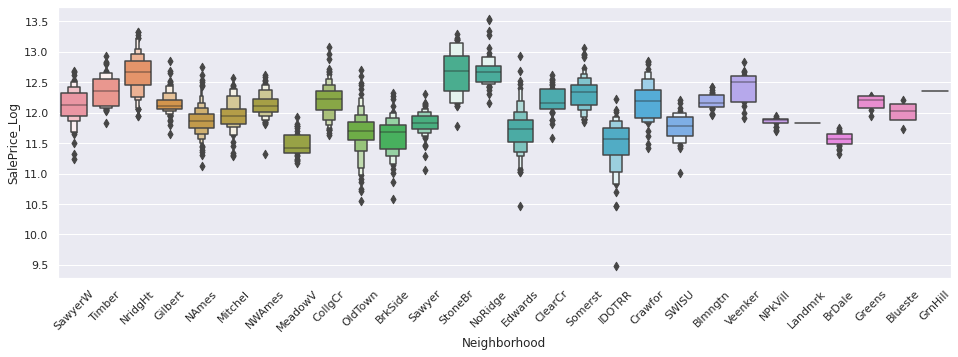

In [346]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.boxenplot(x='Neighborhood', y=train['SalePrice_Log'], data=train, ax=ax)
plt.xticks(rotation=45)
plt.show()

## 3.3 Converting Categorical Features to Numeric Features

In order to use these features, they need to be numeric. So, each category gets a different number:
    
    For example, Neighborhood:
        -'Blmngtn' becomes 1
        -'ClearCr' becomes 2
        -'CollgCr' becomes 3 
    and so on
    
If two categories are sufficiently similar, they can be converged into one category. For example, many of the neighborhoods listed are very similar. So, we classify those as a single group.
    

In [347]:
#Grouping together similar categories
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']


#[]

In [348]:
for df in [train, test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MS Zoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MS Zoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition 2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition 2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['Mas Vnr Type'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['Exter Qual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['Exter Qual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['Exter Qual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['Bsmt Qual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['Bsmt Qual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['Central Air'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['Kitchen Qual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['Kitchen Qual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['Kitchen Qual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['Sale Type'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['Sale Type'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['Sale Type'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  
  

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

### 3.4 Checking correlation to SalePrice for the new numerical columns

We made a lot of changes! Let's see what the correlation of the features to the target looks like now that we've converted all our categories into numeric values

We'll drop any columns that no longer make the cut

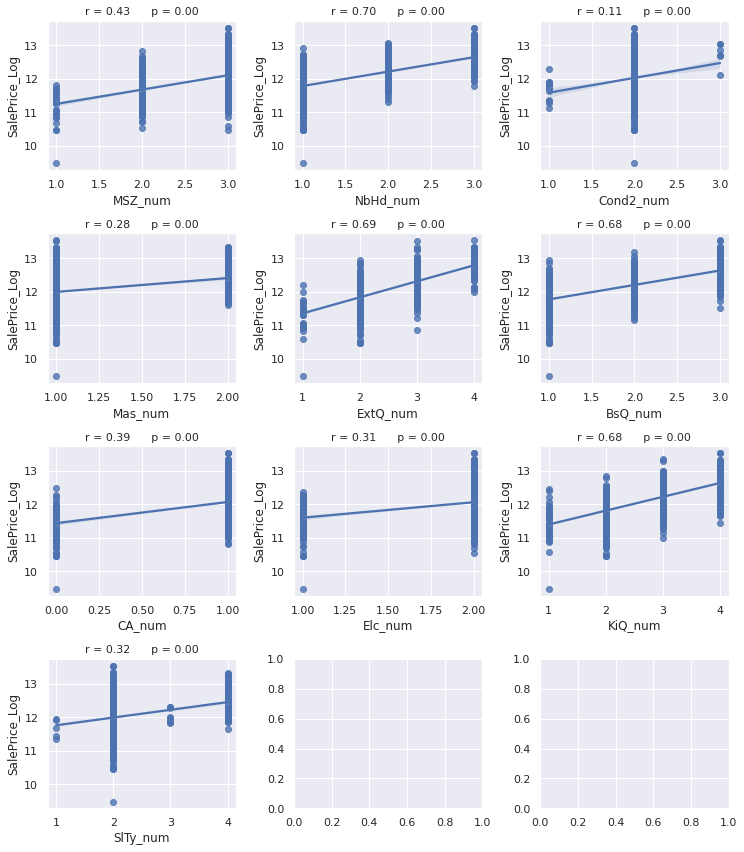

In [349]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(train[new_col_num[i]], train['SalePrice_Log'], ax = axs[r][c])
            stp = stats.pearsonr(train[new_col_num[i]], train['SalePrice_Log'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num).  
These will probably be useful for optimal performance of the Regressors in part 3.

## 3.5 Dropping columns with weak correlation**

Given everything we've learned above, we can drop some columns that are only weakly correlated with the outcome variable.

In [350]:
catg_cols_to_drop = ['Neighborhood' , 'Condition 2', 'Mas Vnr Type', 'Exter Qual', 'Bsmt Qual','Central Air', 'Electrical', 'Kitchen Qual', 'Sale Type']
catg_cols_replaced = ['MS Zoning']

corr1 = train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, 'SalePrice_Log')['SalePrice_Log']


cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

cols_bel_corr_limit_1.remove('Order')

for df in [train, test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)  
    df.drop(catg_cols_replaced,inplace=True,axis=1)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### New Data

Taking a look at the data now that we've made a bunch of changes is good practice. 

In [351]:
train.head()

,Order,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,SalePrice,SalePrice_Log,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,534,7,2007,2007,0.0,0.0,1218.0,1218,1,6,0,2007.0,2.0,576.0,159000,11.976659,7.104965,3,1,3,2,3
1,803,7,1990,1991,234.0,485.0,2158.0,2196,2,7,1,1990.0,3.0,701.0,271900,12.513190,7.694393,3,1,3,2,3
2,956,6,1958,1958,541.0,111.0,819.0,1344,1,7,1,1958.0,2.0,525.0,137500,11.831379,7.203406,3,2,2,1,3
3,460,9,2008,2008,500.0,0.0,1451.0,1456,2,6,1,2008.0,2.0,539.0,248500,12.423198,7.283448,3,3,4,3,4
4,487,7,2004,2004,0.0,241.0,384.0,744,2,7,0,2004.0,2.0,400.0,167000,12.025749,7.225481,3,2,3,2,3


In [352]:
test.head()

,Order,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,SalePrice,SalePrice_Log,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
3,4,7,1968,1968,0.0,1065.0,2110.0,2110,2,8,2,1968.0,2.0,522.0,244000,12.404924,7.654443,3,1,3,1,4
4,5,5,1997,1998,0.0,791.0,928.0,928,2,6,1,1997.0,2.0,482.0,189900,12.154253,7.395722,3,2,2,2,2
6,7,8,2001,2001,0.0,616.0,1338.0,1338,2,6,0,2001.0,2.0,582.0,213500,12.271392,7.198931,3,3,3,2,3
10,11,6,1993,1994,0.0,0.0,763.0,763,2,7,1,1993.0,2.0,440.0,175900,12.077671,7.411556,3,2,2,2,2
13,14,7,1990,1990,0.0,637.0,1300.0,1341,1,5,1,1990.0,2.0,506.0,171500,12.052339,7.201171,3,2,2,2,3


In [353]:
corr2 = train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, 'SalePrice_Log')['SalePrice_Log']

print("The top 10 most correlated features to SalePrice_Log:")
print(ser_corr_2[0:11])

The top 10 most correlated features to SalePrice_Log:
SalePrice_Log    1.000000
SalePrice        0.945548
Overall Qual     0.831278
GrLivArea_Log    0.724089
NbHd_num         0.703663
ExtQ_num         0.688426
BsQ_num          0.682342
Garage Cars      0.679782
KiQ_num          0.676891
Garage Area      0.657748
Total Bsmt SF    0.626714
Name: SalePrice_Log, dtype: float64


### Part 4. Correlation 2- or Multicollinearity 

Linear Regression makes the assumption that all features are independent from one another. 

Therefore, features that are strongly correlated with one another can cause strange things to happen in the regression. We find them with this correlation heat map, and then we choose to keep the one with the strongest correlation to the target variable.

Take a few minutes and try and find some features that are strongly correlated to one another!

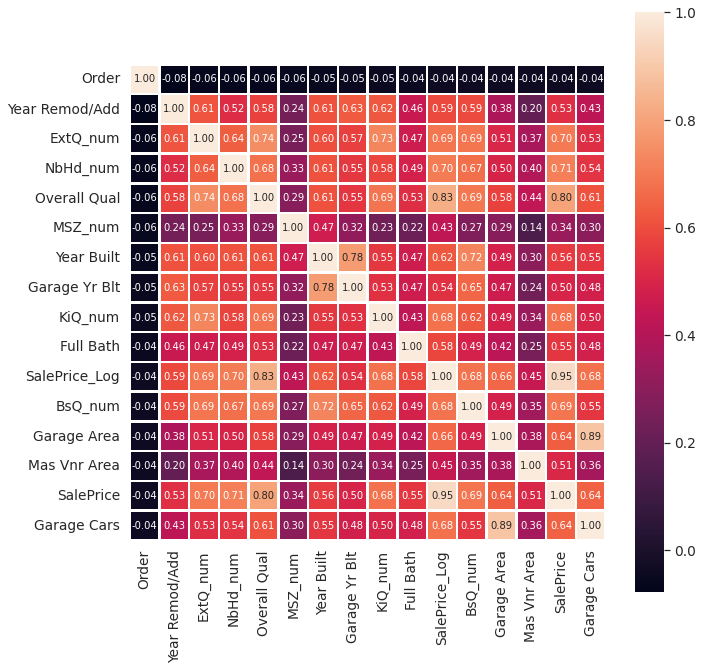

In [354]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)['SalePrice_Log'].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

plot_corr_matrix(train, nr_feats, target)

**Check for Multicollinearity**

Here are the features we found with strong correlation to other, similar features:

    'GrLivArea_Log' and 'TotRmsAbvGrd'

    'GarageCars' and 'GarageArea'

    'TotalBsmtSF' and '1stFlrSF'

    'YearBuilt' and 'GarageYrBlt'

**Of those features we drop the one that has smaller correlation  to Target.**

In [355]:
cols =train.columns
cols = list(train.columns)

for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
    if col in cols: 
        cols.remove(col)

In [356]:
cols = list(cols)
print(cols)

['Order', 'Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'SalePrice', 'SalePrice_Log', 'GrLivArea_Log', 'MSZ_num', 'NbHd_num', 'ExtQ_num', 'BsQ_num', 'KiQ_num']


**List of features used for the Regressors in Part 3**


In [357]:
feats = cols.copy()
feats.remove('SalePrice_Log')
feats.remove('SalePrice')
feats.remove('Order')
#feats.remove('PID')
print(feats)

['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'GrLivArea_Log', 'MSZ_num', 'NbHd_num', 'ExtQ_num', 'BsQ_num', 'KiQ_num']


## Our Final Dataset!

In [358]:
df_train_ml = train[feats].copy()
df_test_ml  = test[feats].copy()

y = train['SalePrice_Log']
y_test = test['SalePrice_Log']

In [359]:
df_train_ml.head()

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2007,2007,0.0,0.0,1218.0,1218,1,6,0,2007.0,2.0,576.0,7.104965,3,1,3,2,3
1,7,1990,1991,234.0,485.0,2158.0,2196,2,7,1,1990.0,3.0,701.0,7.694393,3,1,3,2,3
2,6,1958,1958,541.0,111.0,819.0,1344,1,7,1,1958.0,2.0,525.0,7.203406,3,2,2,1,3
3,9,2008,2008,500.0,0.0,1451.0,1456,2,6,1,2008.0,2.0,539.0,7.283448,3,3,4,3,4
4,7,2004,2004,0.0,241.0,384.0,744,2,7,0,2004.0,2.0,400.0,7.225481,3,2,3,2,3


## 5. Transform Data for Regression

### StandardScaler

We will create a set of the data that is centered and scaled. That means that each variable will be it's own bell curve with a mean of 0.


Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian bell curve with 0 mean and unit variance).

In [360]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [361]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.618124,1.148668,1.063438,-0.571432,-0.956767,0.341814,0.116186,-1.071228,-0.295812,-0.924787,1.123389,0.286157,0.459860,-0.491124,0.443946,-0.839505,0.986525,0.612083,0.715817
1,0.618124,0.590250,0.297649,0.700814,0.084826,2.401737,2.572769,0.736366,0.332716,0.619102,0.443997,1.598059,1.038829,1.316249,0.443946,-0.839505,0.986525,0.612083,0.715817
2,-0.081525,-0.460890,-1.281790,2.369956,-0.718382,-0.532558,0.432678,-1.071228,0.332716,0.619102,-0.834857,0.286157,0.223640,-0.189275,0.443946,0.652722,-0.706753,-0.931827,0.715817
3,2.017423,1.181516,1.111300,2.147041,-0.956767,0.852412,0.714005,0.736366,-0.295812,0.619102,1.163353,0.286157,0.288485,0.056161,0.443946,2.144948,2.679802,2.155993,2.203660
4,0.618124,1.050123,0.919853,-0.571432,-0.439192,-1.485820,-1.074428,0.736366,0.332716,-0.924787,1.003496,0.286157,-0.355329,-0.121583,0.443946,0.652722,0.986525,0.612083,0.715817


**Creating Datasets for ML algorithms**

Copying our train and test datasets into two separate datasets:
  
  1. Without scaling and standardizing
  2. With scaling and standardizing

In [362]:
X = df_train_ml.copy()
y = train['SalePrice_Log']
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = train['SalePrice_Log']
X_test_sc = df_test_ml_sc.copy()
y_test_sc = y_test


In [363]:
X.head()

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2007,2007,0.0,0.0,1218.0,1218,1,6,0,2007.0,2.0,576.0,7.104965,3,1,3,2,3
1,7,1990,1991,234.0,485.0,2158.0,2196,2,7,1,1990.0,3.0,701.0,7.694393,3,1,3,2,3
2,6,1958,1958,541.0,111.0,819.0,1344,1,7,1,1958.0,2.0,525.0,7.203406,3,2,2,1,3
3,9,2008,2008,500.0,0.0,1451.0,1456,2,6,1,2008.0,2.0,539.0,7.283448,3,3,4,3,4
4,7,2004,2004,0.0,241.0,384.0,744,2,7,0,2004.0,2.0,400.0,7.225481,3,2,3,2,3


In [364]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.618124,1.148668,1.063438,-0.571432,-0.956767,0.341814,0.116186,-1.071228,-0.295812,-0.924787,1.123389,0.286157,0.459860,-0.491124,0.443946,-0.839505,0.986525,0.612083,0.715817
1,0.618124,0.590250,0.297649,0.700814,0.084826,2.401737,2.572769,0.736366,0.332716,0.619102,0.443997,1.598059,1.038829,1.316249,0.443946,-0.839505,0.986525,0.612083,0.715817
2,-0.081525,-0.460890,-1.281790,2.369956,-0.718382,-0.532558,0.432678,-1.071228,0.332716,0.619102,-0.834857,0.286157,0.223640,-0.189275,0.443946,0.652722,-0.706753,-0.931827,0.715817
3,2.017423,1.181516,1.111300,2.147041,-0.956767,0.852412,0.714005,0.736366,-0.295812,0.619102,1.163353,0.286157,0.288485,0.056161,0.443946,2.144948,2.679802,2.155993,2.203660
4,0.618124,1.050123,0.919853,-0.571432,-0.439192,-1.485820,-1.074428,0.736366,0.332716,-0.924787,1.003496,0.286157,-0.355329,-0.121583,0.443946,0.652722,0.986525,0.612083,0.715817


# Part 6: Scikit-learn basic regression models and comparison of results

**Test simple sklearn models and compare by metrics**

**We test the following Regressors from scikit-learn:**  
LinearRegression  
   
    
    grid linear 
    grid linear with standardized and scaled data

### 6.1 Linear Regression

Now we'll let the computer find the best linear model.  

Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters.

Cross Validation will also be used. The most popular type of Cross-validation is K-fold Cross-Validation. It is an iterative process that divides the train data into k partitions. Each iteration keeps one partition for testing and the remaining k-1 partitions for training the model. The next iteration will set the next partition as test data and the remaining k-1 as train data and so on. In each iteration, it will record the performance of the model and at the end give the average of all the performance. 


In [365]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
score_calc = 'neg_mean_squared_error'

def get_best_rmse(grid):
    
    best_rmse = np.sqrt(-grid.best_score_)
    print(best_rmse)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_rmse

In [366]:
nr_cv = 5 # setting the number of cross validations used in the Model part 
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [367]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

## 6.2 Evaluate: Root Mean Squared Error

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit

Usually, the model with the lowest RMSE fits the dataset the best

In [368]:
sc_linear = get_best_rmse(grid_linear)
print("The best RMSE is for Grid Linear: ", sc_linear)
print("*"*30)
sc_linear_sc = get_best_rmse(grid_linear_sc)
print("The best RMSE is Grid Linear with SC: ", sc_linear_sc)


0.1485196601916821
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression()
The best RMSE is for Grid Linear:  0.1485196601916821
******************************
0.14851966019168217
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)
The best RMSE is Grid Linear with SC:  0.14851966019168217


From here we can see the Linear Regression with the Standard Scalar data transform did slightly better! It's also good that our results are so similar - that helps me believe we are creating a linear regression on a discernable pattern.  If our data was more random, we would be finding different patterns that were very different from one another.

## 6.3 Evaluate: Predict and RMSE on Test Set


It's important to do our final evaluation on the test set, so we can see if our model can still predict well on data it hasn't yet seen.

In [369]:
y_pred=grid_linear_sc.predict(X_test_sc)

In [370]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
3,12.404924,12.426637
4,12.154253,12.113151
6,12.271392,12.340229
10,12.077671,12.100107
13,12.052339,12.241492


In [371]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.10316112025170047
Mean Squared Error: 0.0255400318212141
Root Mean Squared Error: 0.1598124895657849


These are all very low numbers! It looks like we did a good job in fitting a model to predict the sales price for a house

## 7. Customize: Can Your Random Forest Do Better?

Does changing any of the hyperparameters create a better model? See if you can beat the one the machine made!

This is how a random forest regressor works:



<div> <img src="https://miro.medium.com/max/1400/1*ZFuMI_HrI3jt2Wlay73IUQ.png" alt="Drawing" style="width: 700px;"/></div> 

For our housing dataset, it will look like this, but more complicated:

<div> <img src="https://assets.website-files.com/5e6f9b297ef3941db2593ba1/5f6314a3c5ba908f8f9a43a4_Screenshot%202020-09-17%20at%2009.47.26.png" alt="Drawing" style="width: 700px;"/></div> 




The variables we will be modifying to customize the Random Forest Regressor:

    min_samples_split: The minimum number of samples required to split an internal node aka. when a leaf becomes it's own tree

    n_estimators: number of trees in the forest

    random_state: controls both the randomness of the bootstrapping of the samples used when building trees 

In [ ]:
#replace with your number!
nr_cv = 5 #how many times should it split and check the data?
min_samples_split = [3,4,6,10] #how many leaves until it becomes a tree?
n_estimators = [70,100] #how many trees in the forest?
random_state=[5] #your favorite random number

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' :min_samples_split, 'n_estimators' : n_estimators, 'random_state': random_state }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

In [ ]:
y_pred_forest=grid_rf.predict(X_test_sc)
df_forest = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_forest})
df_forest.head()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_forest))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_forest))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_forest)))

# Congratulations! You've completed a Data Science Pipeline

![](https://previews.123rf.com/images/chuckchee/chuckchee1509/chuckchee150900057/44543743-f%C3%A9licitations-vecteur-de-fond-avec-la-chute-des-confettis.jpg)